In [118]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# reproducibility
SEED = 114514

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [119]:
class PharyngealDataset(Dataset):
    
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return self.features[idx,...], self.labels[idx]

In [120]:
dataset = torch.load('../dataset/data_train/20230519.pt')

# ratio of training
ratio = 0.6

n_train = int(len(dataset)*ratio)
n_test = len(dataset)-n_train
train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [121]:
class LSTMModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Register the max
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing trucated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

In [122]:
# debug

# model = LSTMModel(input_dim=7, hidden_dim=100, layer_dim=1, output_dim=5).to(device)
# for features, labels in train_dataloader:
#     features = features.permute(0, 2, 1)
#     features = features.float().to(device)
#     labels = labels.long().to(device)
#     outputs = model(features)
#     print(features.shape)
#     print(labels.shape)
#     print(outputs.shape)

In [123]:
model = LSTMModel(input_dim=7, hidden_dim=100, layer_dim=1, output_dim=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)

n_epochs = 200
losses = []
for epoch in range(n_epochs):
    epoch_losses = []
    for i, (features, labels) in enumerate(train_dataloader):
        features = features.permute(0, 2, 1)
        features = features.float().to(device)
        labels = labels.long().to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append the loss at the end of each epoch
        epoch_losses.append(loss.item())

    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}')

Epoch 10/200, Loss: 1.4933446645736694
Epoch 20/200, Loss: 1.1389480829238892
Epoch 30/200, Loss: 1.3648958206176758
Epoch 40/200, Loss: 0.5678775906562805
Epoch 50/200, Loss: 0.5701900124549866
Epoch 60/200, Loss: 0.9436588883399963
Epoch 70/200, Loss: 0.4804725646972656
Epoch 80/200, Loss: 0.6971390843391418
Epoch 90/200, Loss: 0.3185439705848694
Epoch 100/200, Loss: 0.5721791982650757
Epoch 110/200, Loss: 0.7864845395088196
Epoch 120/200, Loss: 0.19648541510105133
Epoch 130/200, Loss: 0.24377979338169098
Epoch 140/200, Loss: 0.422172874212265
Epoch 150/200, Loss: 0.046524275094270706
Epoch 160/200, Loss: 0.05123353376984596
Epoch 170/200, Loss: 0.031449828296899796
Epoch 180/200, Loss: 0.013926215469837189
Epoch 190/200, Loss: 0.3790503442287445
Epoch 200/200, Loss: 0.1353650987148285


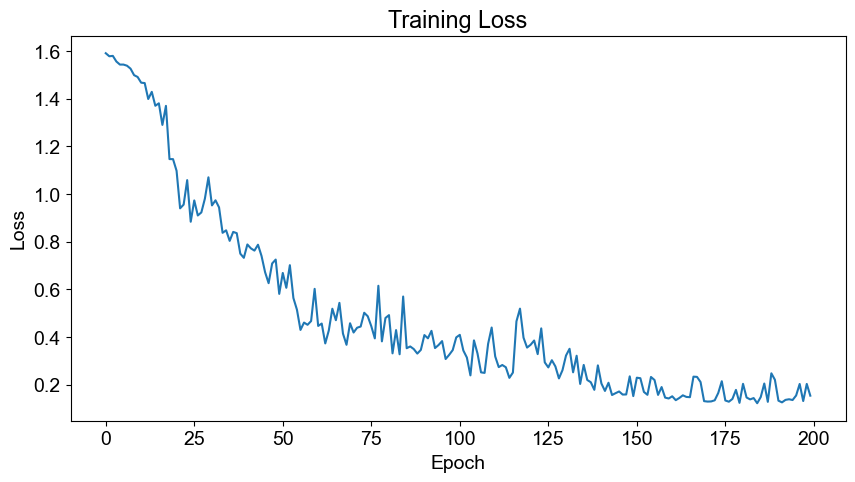

In [124]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot()

ax.plot(losses)
ax.set_title('Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

In [125]:
def eval_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    incorrect_samples = []
    with torch.no_grad():
        for features, labels in dataloader:
            features = features.permute(0, 2, 1)
            features = features.float().to(device)
            labels = labels.long().to(device)

            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Finding the samples for which the prediction was incorrect
            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)
            incorrect_samples.extend(features[incorrect_indices].cpu().numpy())

        return correct / total, np.array(incorrect_samples)

Accuracy of the model on the train data: 94.2857%
Samples that were incorrectly predicted:


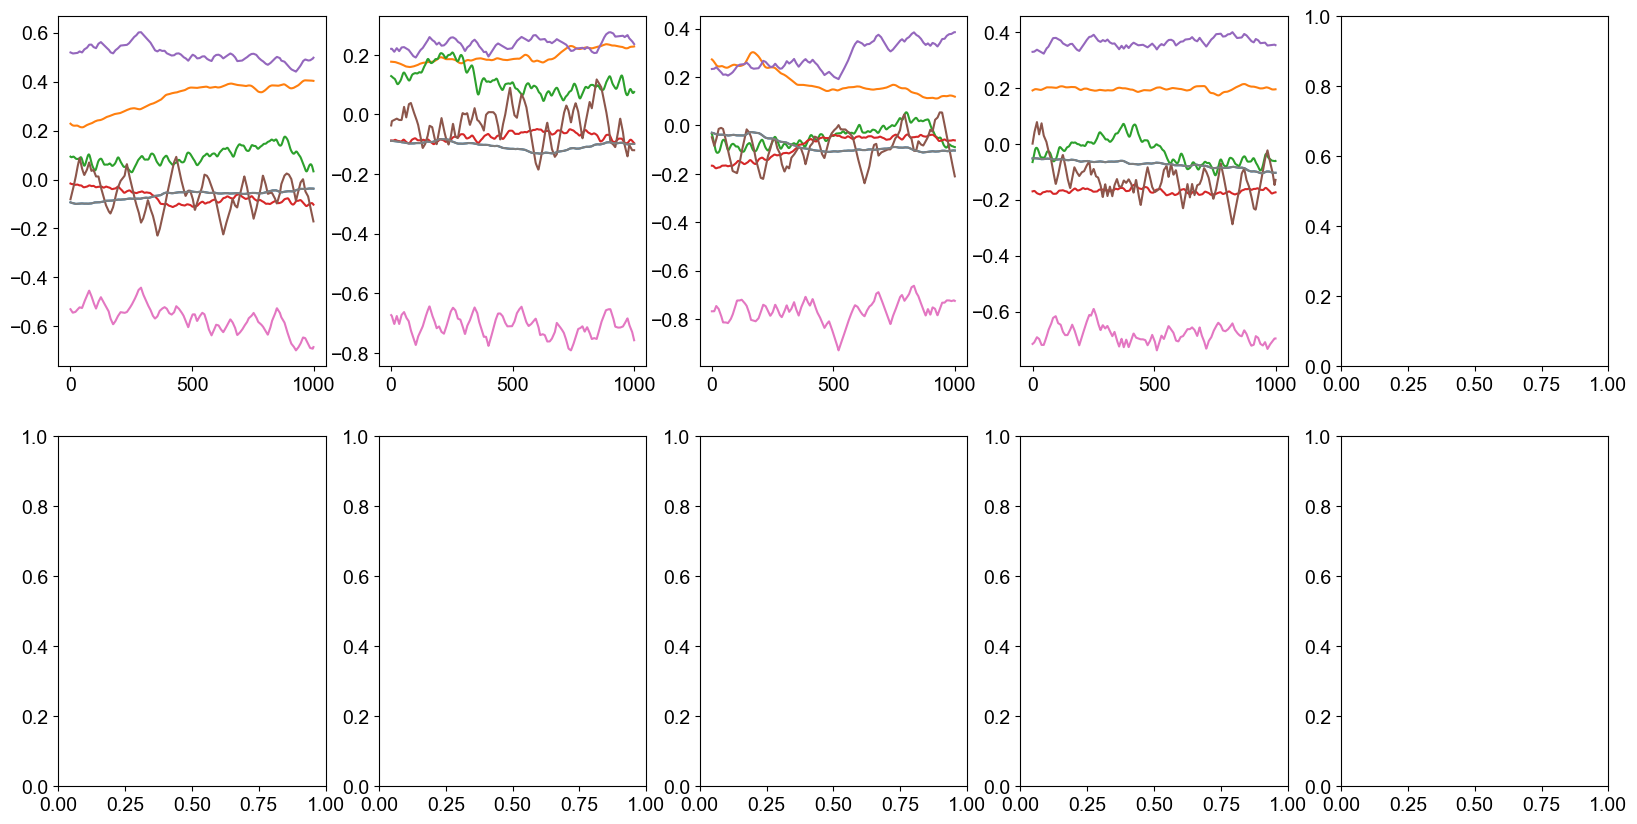

In [126]:
accuracy, incorrect_samples = eval_model(model, train_dataloader)
print('Accuracy of the model on the train data: {:.4f}%'.format(100 * accuracy))
print('Samples that were incorrectly predicted:')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=[20, 10])
for ax, sample in zip(axes.flatten(), incorrect_samples):
    ax.plot(sample)
    ax.plot(sample[:, 0])

plt.show()

Accuracy of the model on the test data: 89.36170212765957%
Samples that were incorrectly predicted:


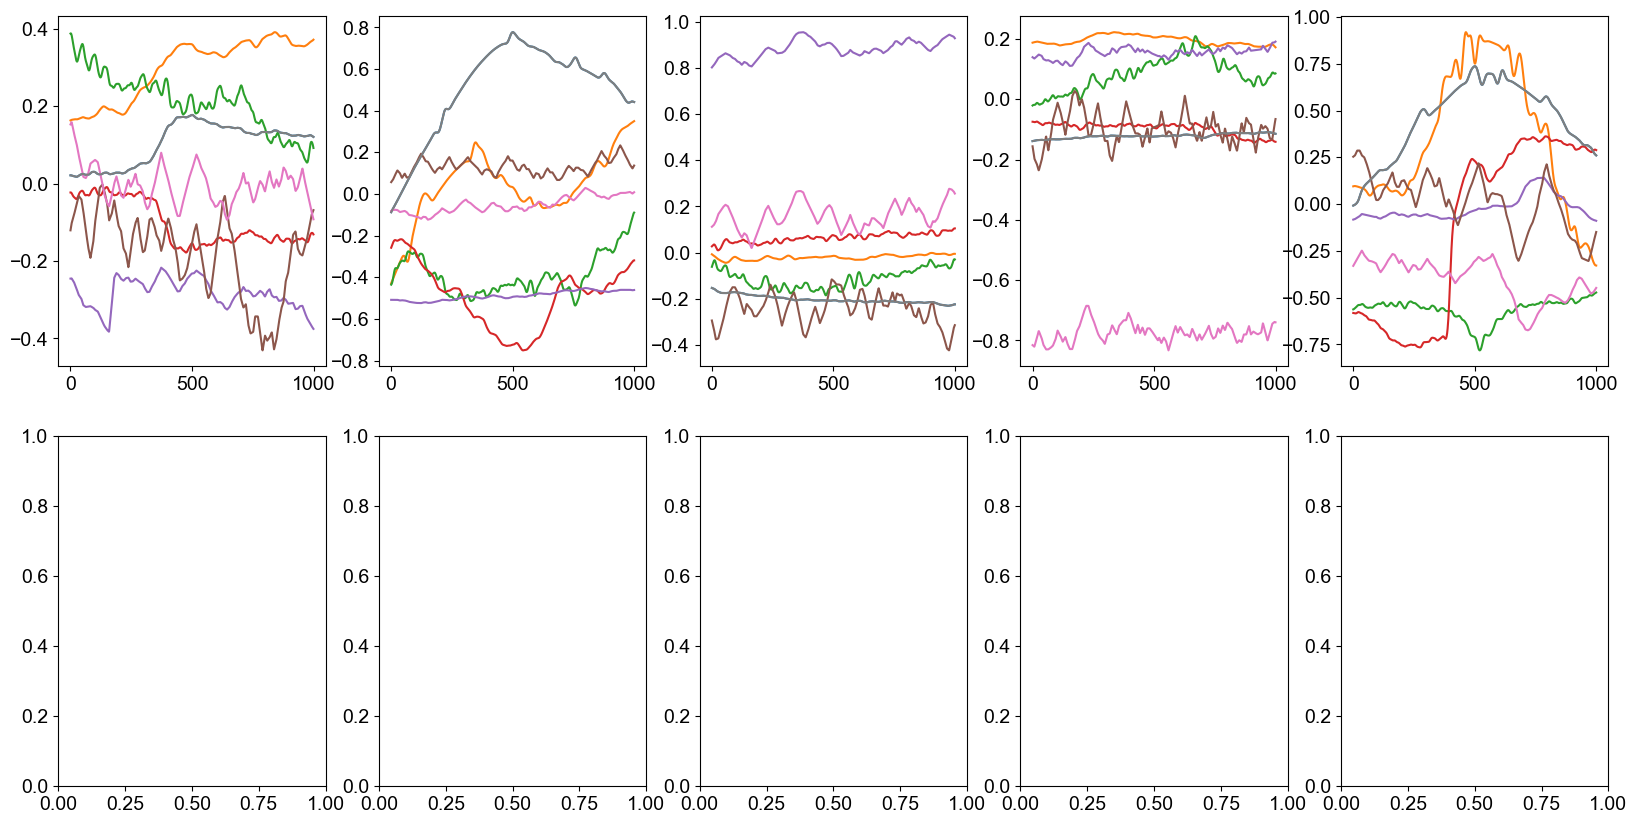

In [127]:
accuracy, incorrect_samples = eval_model(model, test_dataloader)
print('Accuracy of the model on the test data: {}%'.format(100 * accuracy))
print('Samples that were incorrectly predicted:')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=[20, 10])
for ax, sample in zip(axes.flatten(), incorrect_samples):
    ax.plot(sample)
    ax.plot(sample[:, 0])

plt.show()

Visualization

In [128]:
print(model)

LSTMModel(
  (lstm): LSTM(7, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [129]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: ', total_params)

Number of trainable parameters:  44105


In [130]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())

lstm.weight_ih_l0 2800
lstm.weight_hh_l0 40000
lstm.bias_ih_l0 400
lstm.bias_hh_l0 400
fc.weight 500
fc.bias 5
